<a href="https://colab.research.google.com/github/UVA-DS-6050/DS6050---FA24/blob/main/live_sessions/module-5-6/dataLoading_and_ConvolutionNetwork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Python ≥3.5 is required
import sys

# Scikit-Learn ≥0.20 is required
import sklearn

# TensorFlow ≥2.0 is required
import tensorflow as tf
import keras

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


Useful Links
- tf.data doc: https://www.tensorflow.org/guide/data

- keras dataloading doc: https://keras.io/api/data_loading/

Sample Demo of Dataset API

In [3]:
# Create a dataset and batch
dataset = tf.data.Dataset.range(10)
# you can loop through the object and print
for item in dataset:
    print(item)

# calling functions on the dataset object
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

# Create a dataset and batch
dataset = tf.data.Dataset.range(10)
dataset = dataset.map(lambda x: x * 2)

for item in dataset:
    print(item)

# Create a dataset and batch
dataset = tf.data.Dataset.range(10)
dataset = dataset.filter(lambda x: x < 10)

for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)
tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)
tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(10, shape=(), dtype=int64)
tf.Tensor(12, shape=(), dtype=int64)
tf.Tensor(14, shape=(), dtype=int64)
tf.Tensor(16, shape=(), dtype=int64)
tf.Tensor(18, shape=(), dtype=int64)
tf.Tensor(0, shape=(), dt

In [4]:
# Unbatching the data
dataset = dataset.unbatch()

for item in dataset:
    print(item)

ValueError: Cannot unbatch an input with scalar components.

In [5]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_
X_train.shape

(11610, 8)

In [6]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=16)
for X_batch, y_batch in train_set.take(3):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]
 [-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]
 [-1.0344558   1.0581076  -0.8869343  -0.08743899  0.6157541   0.4368748
  -0.75726473  0.64688075]
 [ 0.4675818   0.6625668   0.03120424 -0.02621728 -0.8498953  -0.11217064
  -0.860329    0.72684526]
 [-0.75702035  0.26702586 -0.60196173 -0.07209105  0.28082678  0.36254692
  -0.7338394   0.7768212 ]
 [-0.6998258   1.0581076  -0.06096248 -0.1992738  -0.07052753  0.05529945
   0.

In [7]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

In [8]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

batch_size = 32
print (len(X_train))

model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

model.evaluate(test_set, steps=len(X_test) // batch_size)

new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

C:\Users\zlism\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


ValueError: Argument(s) not recognized: {'lr': 0.001}

In [22]:
# Implement a fit funtion
optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 2
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 724/724

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

optimizer = keras.optimizers.Nadam(lr=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Review Methods in tf.data.Dataset API

In [23]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● bucket_by_sequence_length()A transformation that buckets elements in a `Dataset` by length.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● choose_from_datasets()Creates a dataset that deterministically chooses elements from `datasets`.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Create

Tensorflow Datasets

In [24]:
import tensorflow_datasets as tfds

print(tfds.list_builders())

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())


c:\Users\adewo\anaconda3\envs\dl_venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


['abstract_reasoning', 'aflw2k3d', 'amazon_us_reviews', 'bair_robot_pushing_small', 'bigearthnet', 'binarized_mnist', 'binary_alpha_digits', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_corrupted', 'clevr', 'cnn_dailymail', 'coco', 'coco2014', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'diabetic_retinopathy_detection', 'downsampled_imagenet', 'dsprites', 'dtd', 'dummy_dataset_shared_generator', 'dummy_mnist', 'emnist', 'eurosat', 'fashion_mnist', 'flores', 'food101', 'gap', 'glue', 'groove', 'higgs', 'horses_or_humans', 'image_label_folder', 'imagenet2012', 'imagenet2012_corrupted', 'imdb_reviews', 'iris', 'kitti', 'kmnist', 'lfw', 'lm1b', 'lsun', 'mnist', 'mnist_corrupted', 'moving_mnist', 'multi_nli', 'nsynth', 'omniglot', 'open_images_v4', 'oxford_flowers102', 'oxford_iiit_pet', 

Dl Completed...: 0 url [00:00, ? url/s]
Dl Completed...:   0%|          | 0/3 [00:00<?, ? url/s]
c:\Users\adewo\anaconda3\envs\dl_venv\lib\site-packages\urllib3\connectionpool.py:1061: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  3.73 url/s]

Dl Completed...:  50%|█████     | 2/4 [00:00<00:00,  3.73 url/s]

Dl Completed...:  75%|███████▌  | 3/4 [00:01<00:00,  2.48 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:02<00:00,  1.42 url/s]

Dl Completed...: 100%|██████████| 4/4 [00:03<00:00,  1.06 url/s]


Shuffling...:   0%|          | 0/10 [00:00<?, ? shard/s]

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset mnist downloaded and prepared to C:\Users\adewo\tensorflow_datasets\mnist\1.0.0. Subsequent calls will reuse this data.


(32, 28, 28, 1)
[0 9 9 2 4 3 0 0 0 7 8 1 8 6 6 5 4 6 7 5 1 3 7 7 4 4 7 5 3 4 7 6]


In [25]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(50, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(lr=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5


c:\Users\adewo\anaconda3\envs\dl_venv\lib\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


1875/1875 [==============================] - 15s 8ms/step - loss: 31.7253 - accuracy: 0.8419
Epoch 2/5
1875/1875 [==============================] - 13s 7ms/step - loss: 25.6568 - accuracy: 0.8691
Epoch 3/5
1875/1875 [==============================] - 14s 8ms/step - loss: 24.8474 - accuracy: 0.8742
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 24.6182 - accuracy: 0.8753
Epoch 5/5
1875/1875 [==============================] - 14s 7ms/step - loss: 23.8973 - accuracy: 0.8783


### Convolutional Layer

https://keras.io/api/layers/convolution_layers/convolution2d/

Visualizing CNN
- https://poloclub.github.io/cnn-explainer/

In [ ]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

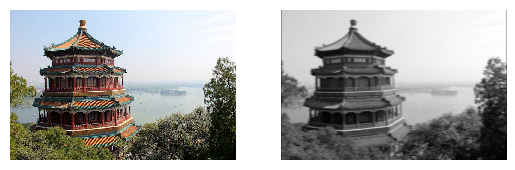

In [29]:
import numpy as np
from sklearn.datasets import load_sample_image

# Load sample images
china = load_sample_image("china.jpg") / 255
flower = load_sample_image("flower.jpg") / 255
images = np.array([china, flower])
batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

plt.subplot(1,2,1);
plot_color_image(china);
plt.subplot(1,2,2)
plt.imshow(outputs[0, :, :, 1], cmap="gray") # plot 1st image's 2nd feature map
plt.axis("off") # Not shown in the book
plt.show()

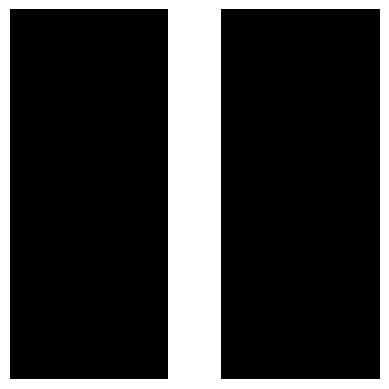

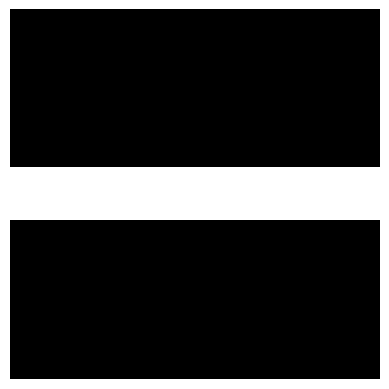

In [27]:
def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")
    
plot_image(filters[:, :, 0, 0])
plt.show()
plot_image(filters[:, :, 0, 1])
plt.show()

In [ ]:
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1,
                           padding="SAME", activation="relu")

"""
Arguments

- filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
- kernel_size: An integer or tuple/list of 2 integers, specifying the height and width of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
- strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the height and width. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
- padding: one of "valid" or "same" (case-insensitive). "valid" means no padding. "same" results in padding with zeros evenly to the left/right or up/down of the input. When padding="same" and strides=1, the output has the same size as the input.
- data_format: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the inputs. channels_last corresponds to inputs with shape (batch_size, height, width, channels) while channels_first corresponds to inputs with shape (batch_size, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be channels_last. Note that the channels_first format is currently not supported by TensorFlow on CPU.
- dilation_rate: an integer or tuple/list of 2 integers, specifying the dilation rate to use for dilated convolution. Can be a single integer to specify the same value for all spatial dimensions. Currently, specifying any dilation_rate value != 1 is incompatible with specifying any stride value != 1.
- groups: A positive integer specifying the number of groups in which the input is split along the channel axis. Each group is convolved separately with filters / groups filters. The output is the concatenation of all the groups results along the channel axis. Input channels and filters must both be divisible by groups.
- activation: Activation function to use. If you don't specify anything, no activation is applied (see keras.activations).
- use_bias: Boolean, whether the layer uses a bias vector.
- kernel_initializer: Initializer for the kernel weights matrix (see keras.initializers). Defaults to 'glorot_uniform'.
- bias_initializer: Initializer for the bias vector (see keras.initializers). Defaults to 'zeros'.
- kernel_regularizer: Regularizer function applied to the kernel weights matrix (see keras.regularizers).
- bias_regularizer: Regularizer function applied to the bias vector (see keras.regularizers).
- activity_regularizer: Regularizer function applied to the output of the layer (its "activation") (see keras.regularizers).
- kernel_constraint: Constraint function applied to the kernel matrix (see keras.constraints).
- bias_constraint: Constraint function applied to the bias vector (see keras.constraints).

Input shape
4+D tensor with shape: batch_shape + (channels, rows, cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (rows, cols, channels) if data_format='channels_last'.

Output shape
4+D tensor with shape: batch_shape + (filters, new_rows, new_cols) if data_format='channels_first' or 4+D tensor with shape: batch_shape + (new_rows, new_cols, filters) if data_format='channels_last'. rows and cols values might have changed due to padding.

Returns
A tensor of rank 4+ representing activation(conv2d(inputs, kernel) + bias).
"""

Training Fashion MNIST with CNN

In [30]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

X_mean = X_train.mean(axis=0, keepdims=True)
X_std = X_train.std(axis=0, keepdims=True) + 1e-7
X_train = (X_train - X_mean) / X_std
X_valid = (X_valid - X_mean) / X_std
X_test = (X_test - X_mean) / X_std

X_train = X_train[..., np.newaxis]
X_valid = X_valid[..., np.newaxis]
X_test = X_test[..., np.newaxis]
print(X_train.shape)

(55000, 28, 28, 1)


In [31]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D,
                        kernel_size=3, activation='relu', padding="SAME")

model = keras.models.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]), # https://keras.io/api/layers/convolution_layers/
    keras.layers.MaxPooling2D(pool_size=2), # https://keras.io/api/layers/pooling_layers/max_pooling2d/
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Flatten(),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=10, activation='softmax'),
])


model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10] # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 [==============================] - 384s 220ms/step - loss: 0.6956 - accuracy: 0.7582 - val_loss: 0.3945 - val_accuracy: 0.8664
Epoch 2/10
1719/1719 [==============================] - 341s 199ms/step - loss: 0.4137 - accuracy: 0.8607 - val_loss: 0.3392 - val_accuracy: 0.8832
Epoch 3/10
 335/1719 [====>.........................] - ETA: 4:27 - loss: 0.3716 - accuracy: 0.8749

KeyboardInterrupt: 